# Kaggle Competition: What's Cooking
Link: https://www.kaggle.com/c/whats-cooking-kernels-only/data

Link to submitted/modified notebook on Kaggle: https://www.kaggle.com/samcoh223/random-forest-classifier?scriptVersionId=24038939

Link to GitHub repo: https://github.com/ktops/kaggle_competition_cooking

### Team Members:
##### Samantha Cohen, Kelsey Toporski, Emil Meireles, William Chen, and Nicolas Ortega. 


## Description of Copmetition // Statement of Purpose

Our group chose the What’s Cooking Competition on Kaggle. This competition challenges us to predict the correct cuisine type (italian, mexican, greek, etc.) of a dish when given a list of ingredients. To tackle this goal, we decided to implement a variety of different machine learning models under two different approaches to data preprocessing. We tried both creating dummy variables  out of the dataset and NLP preprocessing, and then ran the data through models like decision trees, random forests, and linear SVC. Below we will walk through our code and outline our findings, limitations, challenges, and recommendations for moving forward.

## Import Statements: 

In [124]:
import pandas as pd 
import numpy as np
import json
import random

from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score #how good model is 
from sklearn.model_selection import cross_val_predict
import sklearn.ensemble as skens
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from IPython.display import Image
import pydotplus
from sklearn.metrics import classification_report, confusion_matrix
#visualization imports 

from bokeh.layouts import layout
from bokeh.layouts import widgetbox
from bokeh.embed import file_html
from bokeh.io import show
from bokeh.io import output_notebook
from bokeh.models import Text
from bokeh.models import Plot
from bokeh.models import Title
from bokeh.models import Slider
from bokeh.models import Circle
from bokeh.models import Range1d
from bokeh.models import CustomJS
from bokeh.models import HoverTool
from bokeh.models import LinearAxis
from bokeh.models import ColumnDataSource
from bokeh.models import SingleIntervalTicker
from bokeh.plotting import figure
#from bokeh.palettes import Spectral6
from bokeh.palettes import plasma
from bokeh.transform import factor_cmap


# from random import sample 
import warnings
from scipy import stats 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [125]:
warnings.filterwarnings('ignore') 

In [126]:
output_notebook()

Loading BokehJS ...

## PART 1: RANDOM FOREST CLASSIFIER

## 1) Put data in the correct format in order to run RandomForestClassifier later in the code: 

Our data from Kaggle was in json format, and so we will read it in with pd.read_json

In [127]:
test = pd.read_json('test.json')

In [128]:
test.head()

,id,ingredients
0,18009,"[baking powder, eggs, all-purpose flour, raisi..."
1,28583,"[sugar, egg yolks, corn starch, cream of tarta..."
2,41580,"[sausage links, fennel bulb, fronds, olive oil..."
3,29752,"[meat cuts, file powder, smoked sausage, okra,..."
4,35687,"[ground black pepper, salt, sausage casings, l..."


In [129]:
train = pd.read_json('train.json')

In [130]:
train.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


In [131]:
len(train)

39774

#### Explanation: 
The dataset in both train and test is in a format that cannot be used in a Random Forest Classifier. For the train data, the columns need to be every unique ingredient with a 0 or 1 if the ingredient is in a particular cuisine. In the next part, re-load both the test data and train data, and create a dictionary that will be used to create a DataFrame with the information formatted correctly. Do the same thing for the test data as well. 

The test.json data does not have cuisines listed. We are going to use the random forest classifier that is going to be created below on the train.json data. Since the test.json does not have cusines listed, I am going to run cross validation on this data to get an accuracy score. 

## 2) Re-read in json files to be cleaned before putting it into pandas DataFrames. 
- read in test.json and assign it to the variable test_data 
- read in train.json and assign it to the variable data 

In [132]:
with open('train.json') as json_file:
    data = json.load(json_file)
#no cuisine labels 
#cross validate on training dataset

In [133]:
with open('test.json') as json_file:
    test_data = json.load(json_file)
 

#### a) Get a list of all the unique ingredients in both data (train data) and test_data (test data) and assign the resulting lists to two separate variables.  

The train data ingredients, which comes from the values in the variable data, will be a assigned to a list called unique_ingredients. 

The test data ingredients, which comes from the values in the variable test_data, will be assigned to a list called unique_ingredients_test.

In [134]:
#train data 
lst = []
for x in data: 
    id_=x["id"]
    ingredients = x['ingredients']
    for ingred in ingredients:
        lst.append(ingred)


In [135]:
#train data ingredients 
unique_ingredients=list(set(lst))

In [136]:
#test data
lst2 = []
for x in test_data: 
    id_=x["id"]
    ingredients = x['ingredients']
    for ingred in ingredients:
        lst2.append(ingred)


In [137]:
#test data ingredients 
unique_ingredients_test =list(set(lst2))

#### b) Create a dictionary called ingred_value that formats the train data correctly, called data, to be used for a Random Forest Classifier. This dictionary will be used to create a DataFrame called train_df.

This is a dictionary called ingred_value where one of the keys is called 'cusine' and the value is a list of all the cuisines in the dataset. The other keys in the dictionary is all the ingredients in the dataset as keys. The values are 0 or 1 depending on if the particular cuisine mentioned has the ingredient. 

In [138]:
ingred_value = {ingredient: [] for ingredient in unique_ingredients}

In [139]:
ids = []
ciusine = [] 
ingredient_lst = unique_ingredients
ingredients_for_id =[] 
for x in data: 
    id_=x["id"]
    ingredients_in_id = x['ingredients']
    ids.append(id_)
    ciusine.append(x["cuisine"])
    for ingred in ingred_value: 
            if ingred in ingredients_in_id:
                ingred_value[ingred].append(1)
            else: 
                 ingred_value[ingred].append(0)            

In [140]:
# create a key in the ingred_value dictionary called cuisine 
# The value is now a list of cuisines in the dataset 
# the list called ciusine was created above 

ingred_value["cuisine"] = ciusine

In [141]:
#ingred_value

#### c) Created a DataFrame called train_df with the ingred_value dictionary that was created above. 

In [142]:
train_df = pd.DataFrame(ingred_value)

In [143]:
train_df.head()

,sesame oil,salted roasted almonds,puffed rice,frosting,ripe olives,framboise eau-de-vie,baking soda,trout,ketjap,soup mix,...,gaeta olives,Daiya,compote,sweet italian sausage,lemon peel,lavender,low sodium beef bouillon granules,squirt,frozen shelled edamame,cuisine
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,greek
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,southern_us
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,filipino
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,indian
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,indian


##### Explanation: 
The DataFrame train_df is now formatted correctly to perform machine learning classifiers on. 

#### d) Repeat steps b and c above for test_data. Create a dictionary called ingred_value_test that formats the test data correctly, called test_data, to be used for a Random Forest Classifier. This dictionary will be used to create a DataFrame called test_df.

This is a dictionary called ingred_value_test where the keys in the dictionary is all the ingredients in the dataset as keys. The values are 0 or 1 depending on if the particular id mentioned has the ingredient. 

NOTE: as talked about above, the test dataset does not have any cuisines. 

In [144]:
ingred_value_test = {ingredient: [] for ingredient in unique_ingredients_test}


In [145]:
## for test data: 
ids = []
ingredient_lst = unique_ingredients_test
ingredients_for_id =[] 
for x in test_data: 
    id_=x["id"]
    ingredients_in_id = x['ingredients']
    ids.append(id_)
    for ingred in ingred_value_test: 
            if ingred in ingredients_in_id:
                ingred_value_test[ingred].append(1)
            else: 
                 ingred_value_test[ingred].append(0)                

In [146]:
# create a key in the ingred_value_test dictionary called id
# The value is now a list of ids in the dataset 
# the list called ids was created above 

ingred_value_test["id"] = ids

#### c) Created a DataFrame called test_df with the ingred_value_test dictionary that was created above. 

In [147]:
test_df = pd.DataFrame(ingred_value_test)

In [148]:
test_df.head()

,condensed tomato soup,sesame oil,salted roasted almonds,chipotle,green tea,brown butter,puffed rice,frosting,hog casings,ripe olives,...,squirt,ground nuts,olive oil flavored cooking spray,dried beans,smooth pasta,barley,cream cheese lowfat,frozen shelled edamame,diet orange soda,id
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,18009
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,28583
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,41580
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,29752
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,35687


## 3) Perform Analysis on Data 

#### a) How many recipes of each Cuisine are there in the Dataset 

In [149]:
freq_of_cuisines=train_df.groupby("cuisine")["cuisine"] \
    .count() \
    .reset_index(name= "Number_of_Recipes") \
    .sort_values(by = "Number_of_Recipes", ascending = False)

In [150]:
freq_of_cuisines["Number_of_Recipes"].max()

7838

In [151]:
select_tools = ['box_select', 'lasso_select', 'poly_select', 'tap', 'reset']
p = figure(y_range = (0,10000), 
           x_range = (list(freq_of_cuisines["cuisine"])),
           plot_height=650,
           plot_width=700,
           x_axis_label='Cuisine',
           y_axis_label='Number of Recipes',
           title='''The Number of Recipes in the Dataset by Cuisine''',
          )

p.vbar(x='cuisine', top='Number_of_Recipes', width=1, 
       source = freq_of_cuisines, line_color= "black", hover_color="black")
p.xaxis.major_label_orientation = 1

tooltips = [
            ('Cuisine','@cuisine'),
            ('Number of Recipes','@Number_of_Recipes')
           ]

# Add the HoverTool to the figure
p.add_tools(HoverTool(tooltips=tooltips))

show(p)

In [152]:
len(freq_of_cuisines["cuisine"])

20

#### Explanation: 
There are 20 different unique cuisine types in the data. 7,838 recipes in the dataset explain an Italian dish. On the other hand, only 467 recipes in the dataset explain a Brazilian dish. Therefore, due to the fact that their is many more features that explain Italian dishes, we predict it will be easier to classify the cuisines that have more feature information. For example, an Italian dish may be easier to predict than a Brazilian dish because there is more data represented for Italian dishes. Although, if the ingredients in each recipe are extremely unqiue to a particular category than our prediction may not be accurate. 

#### b) Which Ingredients are used the most frequently in recipes regardless of the cuisine category.  

In [153]:
no_cuisine=train_df.drop("cuisine",axis = 1)

In [154]:
sum_of_ingredients = no_cuisine.sum(axis = 0) \
    .reset_index(name = "Ingredients_Count") \
    .sort_values(by = "Ingredients_Count", ascending = False)
sum_of_ingredients.columns = ["Ingredients", "Ingredients_Count"]

In [155]:
top_50_ingredients = sum_of_ingredients.head(50)

In [156]:
select_tools = ['box_select', 'lasso_select', 'poly_select', 'tap', 'reset']
p = figure(y_range =list(top_50_ingredients["Ingredients"]),
           x_range = (0,20000), 
           #x_range = (list(top_50_ingredients["Ingredients"])),
           plot_height=650,
           plot_width=1000,
           x_axis_label='Ingredient Counts',
           y_axis_label='Ingredients',
           title='''The Top 50 Most Popular Ingredients Across All Cuisines ''',
          )

p.hbar( y='Ingredients', right= "Ingredients_Count", left = 0, height = 0.4, color = "orange",  hover_color="black",
       source = top_50_ingredients)


tooltips = [
            ('Ingredient','@Ingredients'),
            ('Ingredient Counts','@Ingredients_Count')
           ]

# Add the HoverTool to the figure
p.add_tools(HoverTool(tooltips=tooltips))

show(p)

##### Explanation: 
Salt is the most ingredient used across all cuisines in the data. The ingredient is used in 18,048 different recipes. Onions and Olive oli the next most used ingredients across all different cuisines. Onions are used in 7,972 recipes and Olive Oil is used 7,971 different recipes. 

#### c) How frequent is the top 3 ingredients used across all 20 cuisines . 

In [157]:
top_three_ingredients =sum_of_ingredients.head(3)

In [158]:
top_3 = list(top_three_ingredients["Ingredients"].values)

In [159]:
top_3

['salt', 'onions', 'olive oil']

In [160]:
label_1 = "{}_freq".format(top_3[0])
label_2 =  "{}_freq".format(top_3[1])
label_3 =  "{}_freq".format(top_3[2])

In [161]:
freq_of_cuisine_ingredients =train_df.groupby(["cuisine"])[top_3[0]] \
    .sum() \
    .reset_index(name="count") \
    .sort_values(by = "count", ascending = False)


In [162]:
freq_of_cuisine_ingredients["ingredient"] = [ top_3[0] for x in freq_of_cuisine_ingredients["cuisine"]]

In [163]:
freq_of_cuisine_2_ingredients =train_df.groupby("cuisine")[top_3[1]] \
    .sum() \
    .reset_index(name="count") \
    .sort_values(by = "count" , ascending = False)

In [164]:
freq_of_cuisine_2_ingredients["ingredient"] = [top_3[1] for x in freq_of_cuisine_ingredients["cuisine"]] 

In [165]:
freq_of_cuisine_3_ingredients =train_df.groupby("cuisine")[top_3[2]] \
    .sum() \
    .reset_index(name=label_3) \
    .sort_values(by = label_3 , ascending = False)

#### c) Compare the number of rows and columns of the train data with the test data

In [166]:
train_df.shape

(39774, 6715)

In [167]:
test_df.shape

(9944, 4485)

##### Explanation: 
The train_df DataFrame has 39774 rows and 6715 columns. The test_df DataFrame has 9944 rows and 4485 columns. The different shapes of the datasets demonstrate a challenge that will occur later on of using the model created for train dataset to predict labels for the test dataset. 

## 4) Split train data DataFrame, called train_df, into variables X and y. 

X is all the variables, in this case ingredients, that will be used to predict the type of cuisine. 

The variable y is the categorical variable cuisine. 

- X is the features, in this case ingredients, that will be used to try and figure out the classification. 
- The values of variable y is what we are trying to predict in this challenge: the type of cuisine given ingredients. 

In [168]:
y = train_df["cuisine"]
X = train_df.drop("cuisine", axis = 1) #all variables 

# first do model then PCA if not 
#first do PCA 

## 5) Assign all the ingredients from the test data DataFrame, called test_df, to the variable X_test. 

X_test is all the variables, in this case ingredients, that will be used to predict the type of cuisine. I am going to drop "id". 

- X_test is the features, in this case ingredients, that will be used to try and figure out the classification.  

In [169]:
X_test = test_df.drop("id", axis = 1)

## 6) Create a Decision Tree Classifier using the package called sklearn on the train data

In [170]:
model = DecisionTreeClassifier(
    random_state=3, 
    criterion='entropy',
    splitter='best', 
    max_depth=5, 
    min_samples_split=2)


#### a) Using the Decision Tree Classifier created, called model, fit the data using the train data: X and y. 

In [171]:
model.fit(X,y)


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=3,
            splitter='best')

#### b) Perform cross validation using the Decision Tree Classifier object, called model, and the train data, called X and y, to get an accuracy score for this model.  

In [172]:
scores_Decision_Tree = cross_val_score(model, X,y, cv=5)


In [173]:
#Get an accuracy score using the mean and standard deviation multiplied by 2
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_Decision_Tree.mean(), scores_Decision_Tree.std() * 2))

Accuracy: 0.31 (+/- 0.00)


##### Explanation: 
The Decision Tree has an accuracy of 31 percent. This is pretty bad model; therefore, a different type of classifer should be used to try and classify the ingredients. In Step 6, a Random Forest Classifer is created to try and increase the accuracy score. 

#### c) Perform cross validation predict using the Decision Tree Classifier object, called model, and the train data, called X and y, to get a prediction of labels for the each recipe. 

In [174]:
y_pred = cross_val_predict(model, X, y, cv=3)

In [175]:
y_pred

array(['mexican', 'mexican', 'chinese', ..., 'mexican', 'mexican',
       'mexican'], dtype=object)

In [176]:

from sklearn.metrics import classification_report, confusion_matrix
#print(confusion_matrix(y, y_pred))
cr = classification_report(y, y_pred)


In [177]:
print(cr)

              precision    recall  f1-score   support

   brazilian       0.00      0.00      0.00       467
     british       0.00      0.00      0.00       804
cajun_creole       0.00      0.00      0.00      1546
     chinese       0.47      0.50      0.48      2673
    filipino       0.81      0.10      0.17       755
      french       0.00      0.00      0.00      2646
       greek       0.00      0.00      0.00      1175
      indian       0.84      0.13      0.23      3003
       irish       0.00      0.00      0.00       667
     italian       0.47      0.56      0.51      7838
    jamaican       0.00      0.00      0.00       526
    japanese       0.84      0.17      0.28      1423
      korean       0.60      0.06      0.11       830
     mexican       0.21      0.84      0.34      6438
    moroccan       0.00      0.00      0.00       821
     russian       0.00      0.00      0.00       489
 southern_us       0.00      0.00      0.00      4320
     spanish       0.00    

In [178]:
# confusion_matrix(y, y_pred)

##### Explanation: 
The model is 31 percent accurate, which is very bad. f1-score is a weighted average of precision and recall, which measures the test's accuracy. Italian is 51 percent accurate

#### d) Create a visualization of the Decision Tree Classifer and export the result as a PNG called cuisine.png

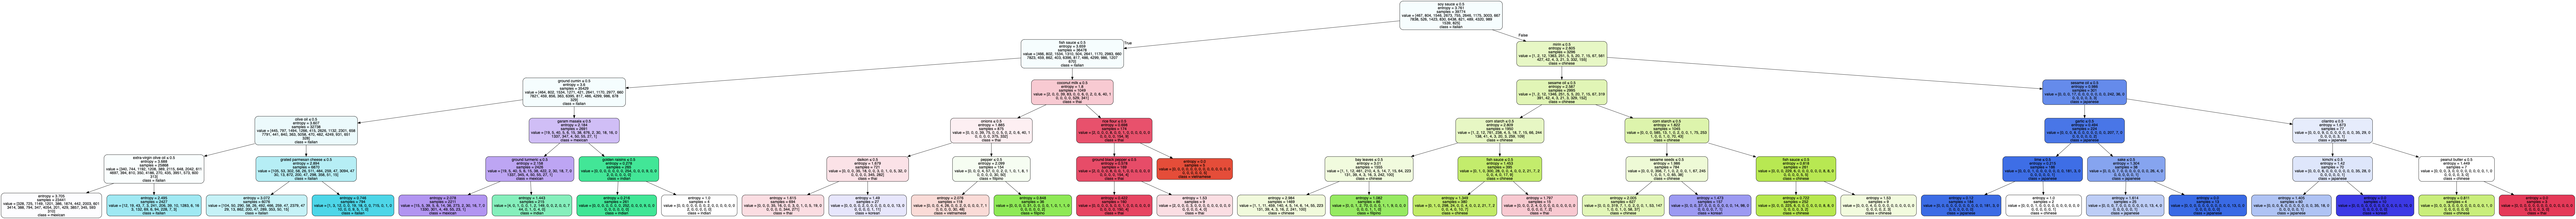

In [196]:
dot_data = export_graphviz(model,
    feature_names=list(X),
    class_names=sorted(y.unique().astype(str)),
    filled=True, 
    rounded=True, 
    special_characters=True, 
    leaves_parallel=False)
 
graph = pydotplus.graphviz.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [197]:
graph.write_png("cuisine.png")

True

## 7) Create a Random Forest Classifier using the package called sklearn on the train data. 

In [183]:
rf_model = skens.RandomForestClassifier(n_estimators=10,oob_score=True, criterion='entropy')

#### a) Using the Random Forest Classifier created, called rf_model, fit the data using the train data: X and y. 

In [184]:
rf_model.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

#### b)Perform cross validation using the Random Forest Classifier object, called rf_model, and the train data, called X and y, to get an accuracy score for this model. 

In [185]:
scores = cross_val_score(rf_model, X,y, cv=5) #do this 5 times and withhold info each time 
#score is the average score for each of the cross validaiton 

In [186]:
#Get an accuracy score using the mean and standard deviation multiplied by 2
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.63 (+/- 0.01)


##### Explanation: 
The accuracy of the Random Forest Classification model is 63 percent. This is much better than the Decision Tree model created above, but it is still not a great model. The reason why the accuracy score is so low is because the number of features is extremely high, making it hard to classify each cuisine. 

#### c) Perform cross validation predict using the Random Forest Classifier object, called rf_model, and the train data, called X and y, to get a prediction of labels for the each recipe. 

In [187]:
y_pred = cross_val_predict(rf_model, X, y, cv=5)

In [188]:
y_pred

array(['greek', 'southern_us', 'mexican', ..., 'southern_us', 'chinese',
       'mexican'], dtype=object)

In [189]:
train_df_with_predict = train_df.copy()
train_df_with_predict["predicted_labels"] = y_pred

In [190]:
correct = train_df_with_predict[train_df_with_predict["cuisine"] ==train_df_with_predict["predicted_labels"]]

In [191]:
incorrect = train_df_with_predict[train_df_with_predict["cuisine"] != train_df_with_predict["predicted_labels"]]

In [192]:
correct_cuisine= correct.groupby("cuisine")["predicted_labels"] \
    .count() \
    .reset_index(name ="Number_Correct")

In [193]:
incorrect_cuisine=incorrect.groupby("cuisine")["predicted_labels"] \
    .count() \
    .reset_index(name ="Number_Incorrect")

In [194]:
correct_and_incorrect= incorrect_cuisine.merge(correct_cuisine, on = "cuisine")

In [195]:
correct_and_incorrect

,cuisine,Number_Incorrect,Number_Correct
0,brazilian,274,193
1,british,636,168
2,cajun_creole,684,862
3,chinese,553,2120
4,filipino,441,314
5,french,1522,1124
6,greek,656,519
7,indian,544,2459
8,irish,503,164
9,italian,1301,6537


In [198]:
from bokeh.models import FactorRange
cuisines = list(correct_and_incorrect['cuisine'])
right_or_wrong = ['incorrect', 'correct']

data = {'cuisines': cuisines, #years = cuisines 
        'incorrect': list(correct_and_incorrect['Number_Incorrect']),
        'correct': list(correct_and_incorrect['Number_Correct'])}

# data

x = [(c, rw) for c in cuisines for rw in right_or_wrong]
counts = sum(zip(data['incorrect'], data['correct']), ())



source = ColumnDataSource(data=dict(x=x, counts=counts))

plot = figure(x_range=FactorRange(*x), plot_height=800, plot_width=1200, title="Comparing Accuracy of Predicted Labels by Cuisines")

plot.vbar(x='x', top='counts', width=1, source=source, line_color='white',
          fill_color=factor_cmap('x', palette=['tomato', '#3CB371'], factors=right_or_wrong, start=1, end=2))
    
plot.y_range.start = 0
plot.x_range.range_padding = 0.01
plot.xaxis.major_label_orientation = 1.55
plot.xaxis.group_label_orientation = 1
plot.xgrid.grid_line_color = None
plot.xaxis.axis_label = 'Cuisines'
plot.yaxis.axis_label = 'Number of Total Labels Predicted'

tooltips = [
            ('counts','@counts'),
            ('Category','@x')
           ]

# Add the HoverTool to the figure
plot.add_tools(HoverTool(tooltips=tooltips))

show(plot)

#### Explanation: 
Running our data through the random forest model, we were able to produce the graph above, showing how many labels we predicted correctly and incorrectly for each cuisine. We know we had the most Italian and Mexican examples in our dataset, so it makes sense as shown above that we would see more of those correct than we would of thet Brazilian category, because we had the least amount of examples to train for that cuisine type. We can also see that out of the 20 cuisine categories, only 6 of them had more correct than incorrect labels, but because we had so many right in the larger cuisine categories, we end up with more right than wrong overall.

In [199]:
cr_rf_model = classification_report(y, y_pred)

In [200]:
print(cr_rf_model)

              precision    recall  f1-score   support

   brazilian       0.62      0.41      0.50       467
     british       0.33      0.21      0.26       804
cajun_creole       0.64      0.56      0.59      1546
     chinese       0.62      0.79      0.69      2673
    filipino       0.53      0.42      0.47       755
      french       0.41      0.42      0.42      2646
       greek       0.60      0.44      0.51      1175
      indian       0.70      0.82      0.76      3003
       irish       0.44      0.25      0.32       667
     italian       0.63      0.83      0.72      7838
    jamaican       0.74      0.28      0.41       526
    japanese       0.66      0.54      0.60      1423
      korean       0.70      0.46      0.55       830
     mexican       0.75      0.85      0.80      6438
    moroccan       0.74      0.34      0.47       821
     russian       0.48      0.15      0.23       489
 southern_us       0.59      0.57      0.58      4320
     spanish       0.48    

## 8) Examine the feature importance of the Random Forest Classifer created above, called rf_model. Since the accuracy of the model is low, try removing the features that have low feature importance from the DataFrame and re-create the random forest classifer without these features. 

The features with the lowest feature importance may be throwing off the accuracy of the model. In the below code we try to remove them to see if it helps to increase the accuracy of the model. 

In [247]:
feature_importance =rf_model.feature_importances_
#more pasta: italian --grain types might be a predictor 
#rice in more asian 

In [248]:
feat_imp=pd.DataFrame({"feature_importance":feature_importance}, index = X.columns) 

In [249]:
feat_imp = feat_imp.sort_values(by = "feature_importance", ascending = False)
feat_imp.head()

,feature_importance
soy sauce,0.018400
olive oil,0.015932
extra-virgin olive oil,0.011305
salt,0.010782
ground cumin,0.010319


In [250]:
feat_imp=feat_imp.reset_index()
feat_imp.columns = ["Ingredients","feature_importance"]

In [251]:
feat_imp.head()

,Ingredients,feature_importance
0,soy sauce,0.018400
1,olive oil,0.015932
2,extra-virgin olive oil,0.011305
3,salt,0.010782
4,ground cumin,0.010319


#### a) Create a Bar graph using Bokeh to show the feature importance of the top 100 most important ingredients in the Dataset

In [252]:
top_100=feat_imp.head(100)

In [272]:
select_tools = ['box_select', 'lasso_select', 'poly_select', 'tap', 'reset']
p = figure(y_range = (0,0.02), 
           x_range = (list(top_100["Ingredients"])),
           plot_height=700,
           plot_width=1000,
           x_axis_label='Ingredients',
           y_axis_label='Feature Importance',
           title='''Feature Importance of the Top 100 most Important Ingredients in the Dataset''',
          )

p.vbar(x='Ingredients', top= "feature_importance", 
       width=0.8,
       color ="red", 
       line_color= "black",
       hover_color="black",
       source = top_100)

#     x='Ingredients', top='feature_importance', width=1, 
#        source = top_300, line_color= "black", hover_color="black")
p.xaxis.major_label_orientation = 1.5

tooltips = [
            ('Ingredients','@Ingredients'),
            ('Feature Importance','@feature_importance')
           ]

# Add the HoverTool to the figure
p.add_tools(HoverTool(tooltips=tooltips))

show(p)

##### Explanation: 
After examining the feature importances of the ingredients, we found that Soy Souce is the most importance ingredient in the dataset. Soy souce has a feature importance of 0.021204. This is not surpising because Soy Sauce is a prime ingredient in many Asian foods; therefore, if soy sauce is listed as an ingredient it is likely an asian dish-- Chinese, Japanese, etc. As well, Olive Oil is the second most important ingredient. Olive Oil may help predict whether a dish is an Italian or Greek cuisine. Ingredients that were more specific and maybe used less were less important, such as "Crystal Farms Shredded Goulda Cheese".

#### b) Drop the features that are equal to the minimum feature importance in the dataset. Assign the filtered DataFrame to the variable smalled_features

In [254]:
smallest_features = feat_imp[feat_imp["feature_importance"]==feat_imp["feature_importance"].min()]

In [255]:
# train_df

In [256]:
columns_to_drop =list(smallest_features["Ingredients"])
train_data_droppped_smallest_features = train_df.drop(columns = columns_to_drop,  axis = 1)

In [257]:
X_no_0_features = train_data_droppped_smallest_features.drop("cuisine", axis =1)

In [258]:
# train_data_droppped_smallest_features

#### c) Creat a new Random Forest Classifer without features that have a minimum feature importance 

In [259]:
rf_model_dropped_feats = skens.RandomForestClassifier(n_estimators=10,oob_score=True, criterion='entropy')
rf_model_dropped_feats.fit(X_no_0_features,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

#### d) Use cross validation on the Random Forest Classifier created above and with using X_no_0_features 

In [260]:
scores_dropped_feats = cross_val_score(rf_model_dropped_feats, X_no_0_features,y, cv=5)

#### e) Calculate the Accuracy of the Random Forest Classifier 

In [261]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_dropped_feats.mean(), scores_dropped_feats.std() * 2))

Accuracy: 0.63 (+/- 0.01)


##### Explanation: 
The accuracy was not improved by dropping all the features that are equal to the lowest feature importance. The of the random forest classifier is still 63 percent. 

## 9) Use PCA to reduce the number of dimensions in the DataFrame. Then use PCA to create a new Random Forest Classifier to try and potentially increase accuracy of the model. 

In [262]:
from sklearn.decomposition import PCA

In [263]:
def create_randomForestClassifer(x,y):
    rf_model_pca = skens.RandomForestClassifier(n_estimators=10,
                                                oob_score=True, 
                                                criterion='entropy')
    rf_model_pca.fit(x100,y)
    return rf_model_pca

In [264]:
pca_1000 = PCA(n_components = 1000)
x1000 = pca_1000.fit_transform(X)


In [265]:
pca_100 = PCA(n_components = 100)
x100 = pca_100.fit_transform(X)

In [266]:
pca_20 = PCA(n_components = 20)
x20 = pca_20.fit_transform(X)

In [267]:
rf_model_pca_1000 = create_randomForestClassifer(x1000,y)
rf_model_pca_100 = create_randomForestClassifer(x100,y)
rf_model_pca_20 = create_randomForestClassifer(x20,y)

In [268]:
scores_rf_model_pca_1000 = cross_val_score(rf_model_pca_1000, x1000,y, cv=5) 
scores_rf_model_pca_100 = cross_val_score(rf_model_pca_100, x100,y, cv=5) 
scores_rf_model_pca_20 = cross_val_score(rf_model_pca_20, x20,y, cv=5) 

In [269]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_rf_model_pca_1000.mean(), scores_rf_model_pca_1000.std() * 2))



Accuracy: 0.46 (+/- 0.01)


In [270]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_rf_model_pca_100.mean(), scores_rf_model_pca_100.std() * 2))



Accuracy: 0.51 (+/- 0.01)


In [271]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_rf_model_pca_20.mean(), scores_rf_model_pca_20.std() * 2))



Accuracy: 0.49 (+/- 0.01)


##### Explanation: 
Reducing the dimensions using PCA does not increase the accuracy score of the random forest classifer, stalling out at around 50%

In [273]:
rf_model_pca = skens.RandomForestClassifier(n_estimators=10,oob_score=True, criterion='entropy')
rf_model_pca.fit(x100,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [274]:
scores = cross_val_score(rf_model_pca, x100,y, cv=5) 

In [275]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.51 (+/- 0.01)


##### Explanation: 
PCA is used to reduce the number of dimensions down to 100 components in the dataset train to try to increase the accuracy score. After reducing the dimensions down, and fitting the data to the model, a new random forest classifer is created. The accuracy score is now 52 percent. This is less than the accuracy score of the random forest classifier when using all features in the dataset.  The accuracy score when using all feature columns is 63 percent. This is a 9 percent drop in accuracy.

## 10) Get predicted labels for the test data 

In [276]:
#get all the same columns in both X_test and X_train. 

#### a) Filter X_train and X_test to only have columns that are represented in both DataFrames

In [277]:
# X[~X.isin(X_test.columns())]
columns_in_train = set(X.columns)
columns_in_test = set(X_test.columns)
columns_in_both = list(columns_in_train & columns_in_test)
new_df_with_columns_in_both_train = X[columns_in_both]
new_df_with_columns_in_both_test = X_test[columns_in_both]


#### b) Create a random forest classifier object, and then fit the model with new_df_with_columns_in_both_train and y

In [278]:
rf_model_for_test = skens.RandomForestClassifier(n_estimators=10,
                                                oob_score=True, 
                                                criterion='entropy')


In [279]:
rf_model_for_test.fit(new_df_with_columns_in_both_train,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

#### c) Get predicted labels for new_df_with_columns_in_both_test 

In [280]:
predicted_y_for_test = rf_model_for_test.predict(new_df_with_columns_in_both_test)

#### d) Create a copy of the test_df and assign it to the variable test_df_predicted. Add a column to test_df_predicted with the predicted labels, called predicted_y_for_test. 

In [281]:
test_df_predicted = test_df.copy()

test_df_predicted["predicted_labels"] = predicted_y_for_test

In [282]:
test_df_predicted.head()

,condensed tomato soup,sesame oil,salted roasted almonds,chipotle,green tea,brown butter,puffed rice,frosting,hog casings,ripe olives,...,ground nuts,olive oil flavored cooking spray,dried beans,smooth pasta,barley,cream cheese lowfat,frozen shelled edamame,diet orange soda,id,predicted_labels
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,18009,irish
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,28583,southern_us
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,41580,italian
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,29752,cajun_creole
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,35687,italian


#### e) Perform cross validation using the Random Forest Classifier object, called rf_model_for_test, and the train data, called new_df_with_columns_in_both_train and y, to get an accuracy score for this model. 

In [283]:
scores_of_new_model = cross_val_score(rf_model_for_test, new_df_with_columns_in_both_train,y, cv=5)

In [284]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_of_new_model.mean(), scores_of_new_model.std() * 2))

Accuracy: 0.63 (+/- 0.01)


##### Explanation: 
Here we get to see how well our model did at predicting labels for cuisines in our test dataset, as shown in the last column of the table above. We can see that it predicted labels with the same accuracy as above.

#### f) Write the contents of test_df_predicted to a json file, and a csv. The csv file will be submitted to kaggle!¶

In [285]:
#convert the pandas dataframe test_df_predicted to a dictionary
result = test_df_predicted.to_dict('records')

In [286]:
test_result = [] 
for d in result: 
    dic_to_add = {} 
    id_ = d["id"]
    cuisine_type = d['predicted_labels']
    #add to dictionary 
    dic_to_add['id'] = id_
    dic_to_add['cuisine'] = cuisine_type 
    #create a list of ingredients 
    ingredient_list = [k for k in d if d[k] == 1] 
    
    dic_to_add['ingredients'] = ingredient_list
    test_result.append(dic_to_add)

In [287]:
#show the first dictionary to check the formatting 
test_result[0]

{'id': 18009,
 'cuisine': 'irish',
 'ingredients': ['eggs',
  'raisins',
  'milk',
  'baking powder',
  'white sugar',
  'all-purpose flour']}

In [288]:
#write the file to json
file= open("submission.json", "w") 
file.write(json.dumps(test_result))
file.close()

In [289]:
#create the submission.csv 
final_for_submission = test_df_predicted[["id","predicted_labels"]]
final_for_submission.columns = ["id","cuisine"]

In [290]:
final_for_submission.to_csv("submission.csv", index=False, header = True)

#### Explanation:
<b>submission.csv:</b> this file has two columns id and cuisine. The id is the id from test, and the cuisine is the predicted cuisine for the particular id in the test dataset.

<b>submission.json:</b> is a list with dictionaries for each id in the test dataset. Each dictionary has 3 keys: id, cuisine, and ingredients. The value the key "Ingredients", is a list of ingredients for the particular id. The value of the key "cuisine" is the predicted cuisine label given by the model.

## 11) Test to see if our model is better than a random test 

In [291]:
picking_a_label_at_random = list(np.random.random_integers(0, 19, size = len(X)))

In [292]:
#get a list of the unique category labels 
labels = list(y.unique())

In [293]:
#create a dictionary that maps 0-19 to their label names 
map_labels = {i : labels[i] for i in range(len(labels)) }

In [294]:
y_labels_for_random=[map_labels[x] for x in picking_a_label_at_random]

In [295]:
accuracy = accuracy_score(y, y_labels_for_random)

In [296]:
accuracy

0.04983154824759893

### Explanation: 
To help gadge the usefulness of the model we wanted to test whether picking a label at random has greater accuracy than the random forest classifier model created. A random test provides a baseline for our model to be compared too. After conducting a random test, and then computing the accuracy of these predictions, we found that the random test has an accuracy of around 5%. This is less than the current accuracy score of the random forest classifier. Our model has an accuracy score of 63%; therefore, this is a comparatively better model than choosing a label at random. 

## PART 2: NLP

## 12) Try doing NLP To Increase Accuracy 

In this section, we try to use an NLP approach to get a better accuracy.

In [297]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from nltk import wordpunct_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

In [298]:
df_train = pd.read_json("train.json")
df_test = pd.read_json("test.json")

In [299]:
df_train.shape, df_test.shape

((39774, 3), (9944, 2))

#### Pre-process text: make new column with long string with all ingredients for vectorization

In [300]:
#stemmer and lemmatizer objects
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

### create function that cleans data, for use in apply function below 
def clean(x):
    prePro = ""
    
    x = " ".join(x)
    x = x.lower()
    x = re.sub("[-'%]", " ", x)
    x = re.sub("[^0-9a-zA-Z ]+", "", x)
    x = re.sub("[^\x00-\x7f]", "", x) #removes non-ASCII characters
    
    #tokenization
    words = wordpunct_tokenize(x)
    words_out = []
    
    #stem and lemmatize
    for word in words:
        word = lemmatizer.lemmatize(stemmer.stem(word))
        words_out.append(word)
        
    prePro = (' '.join(words_out))    
    
    return prePro

# clean(df_train.ingredients[120])

In [301]:
%%time
#single string for both train and test df's
df_train["prePro"] = df_train.ingredients.apply(lambda x: clean(x))
df_test["prePro"] = df_test.ingredients.apply(lambda x: clean(x))

CPU times: user 34 s, sys: 953 ms, total: 34.9 s
Wall time: 43.7 s


### EDA

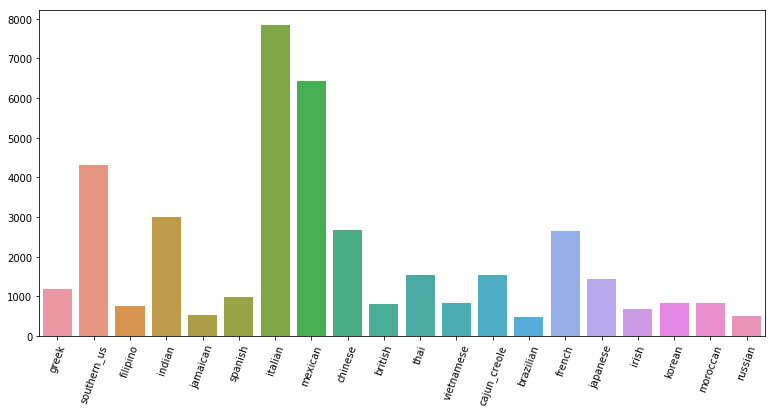

In [302]:
# checking ingredient frequency

#dict_count for cuisines
cuisine_count = dict()
for i in df_train["cuisine"]:
    if i in cuisine_count:
        cuisine_count[i] += 1
    else:
        cuisine_count[i] = 1


fig, ax = plt.subplots(figsize=(13,6))

#graphing barplot
sns.barplot(x=list(cuisine_count.keys()), y=list(cuisine_count.values()))
plt.xticks(rotation=70);

In [303]:
#get df_train target variables
y_train = df_train.cuisine
X_train = df_train.prePro

#only get X data (recipes)
X_test = df_test.prePro

In [304]:
df_test.head()

,id,ingredients,prePro
0,18009,"[baking powder, eggs, all-purpose flour, raisi...",bake powder egg all purpos flour raisin milk w...
1,28583,"[sugar, egg yolks, corn starch, cream of tarta...",sugar egg yolk corn starch cream of tartar ban...
2,41580,"[sausage links, fennel bulb, fronds, olive oil...",sausag link fennel bulb frond oliv oil cuban p...
3,29752,"[meat cuts, file powder, smoked sausage, okra,...",meat cut file powder smoke sausag okra shrimp ...
4,35687,"[ground black pepper, salt, sausage casings, l...",ground black pepper salt sausag case leek parm...


In [305]:
df_train.head()

,cuisine,id,ingredients,prePro
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes...",romain lettuc black oliv grape tomato garlic p...
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g...",plain flour ground pepper salt tomato ground b...
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g...",egg pepper salt mayonais cook oil green chili ...
3,indian,22213,"[water, vegetable oil, wheat, salt]",water veget oil wheat salt
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe...",black pepper shallot cornflour cayenn pepper o...


## Classification of recipe data: Logistic Regression, Decision Tree, Random Forest, SVM

### Two Vectorization Approaches: Bag-of-Words and TF-IDF
- Logistic Regression, 
- Decision Tree, 
- Random Forest, 
- Linear SVC, 
- and truncated SVD with t-SNE visualization. 

In [306]:
##### BAG-OF-WORDS VECTORIZER INSTANTIATION
## Getting X, y values vectorized with Bow (CountVectorizer)

#initialize BoW vectorizer
vec1 = CountVectorizer()

# fit and transform ingredients into CountVectors
X = vec1.fit_transform(X_train.values)

le = LabelEncoder()
y = le.fit_transform(y_train)

print("Size of bag-of-word matrix: ", X.shape) #output: Sparse matrix

# encoding labels to represent cuisine for prediction


print("\nClass/recipe labels --")
le.classes_ #attribute, holds label for each class/ingredient

Size of bag-of-word matrix:  (39774, 2631)

Class/recipe labels --


array(['brazilian', 'british', 'cajun_creole', 'chinese', 'filipino',
       'french', 'greek', 'indian', 'irish', 'italian', 'jamaican',
       'japanese', 'korean', 'mexican', 'moroccan', 'russian',
       'southern_us', 'spanish', 'thai', 'vietnamese'], dtype=object)

### Initialize all ML models

In [307]:
%%time

#####generate a reduced X based on truncated SVD. Determine the optimum number of components (based on explained 
#####variance) create duplicate models but fitted with the newly reduced X (reduced sparse matrix) 


#initialize logistic regression object
lg = LogisticRegression(
    solver="saga",
    max_iter=10000).fit(X, y)

# initializing decision tree classifier object
dt = DecisionTreeClassifier(
    random_state=3, 
    criterion='entropy',
    splitter='best', 
    max_depth=None, 
    min_samples_split=2).fit(X, y)

#initializing random forest model, fit 
rf = RandomForestClassifier(
    random_state = 3,
    criterion = "entropy",
    max_features="sqrt",
    max_depth = None,
    min_samples_split = 2).fit(X, y)

#initializing linear SVC model, fit
lsvc = LinearSVC(
    random_state=3, 
    max_iter=10000).fit(X, y)

CPU times: user 4min 41s, sys: 1.87 s, total: 4min 43s
Wall time: 5min 5s


In [308]:
##Function will be applied to all models. Accepts one recipe, and returns the prediction 
##(use for loop to aggregate predictions) 

#input: recipe <str>, model (initialized above)
#output: cleaned and transformed prediction, according to picked model 

def classify_cuisine(recipe, model):
    ings = []
    ings.append(clean(recipe))
    ings = vec1.transform(ings)
    
    predict = model.predict(ings)
    
    #transforms labels back to original encoding
    return le.inverse_transform(predict) 

### Logistic Regression

In [309]:
%%time
#Using for loop, create list of tuples (id from test dataframe, prediction for the id) 
y_pred_logreg = []

for recipe in X_test.values: #strings
    # apply cuisine classification function previously defined
    a = classify_cuisine(recipe.split(), lg)
    y_pred_logreg.append(a)
    
# #zipping into iterable tuple, more efficient
id_res_lg = list(zip(df_test.id, y_pred_logreg)) 

CPU times: user 7.18 s, sys: 291 ms, total: 7.47 s
Wall time: 7.97 s


In [310]:
#getting dataframe, imitating sample output (df)
logreg_results = pd.DataFrame(id_res_lg, columns=["test_index","prediction"])
logreg_results.head()

,test_index,prediction
0,18009,[british]
1,28583,[southern_us]
2,41580,[italian]
3,29752,[cajun_creole]
4,35687,[italian]


In [311]:
%%time
#evaluating model using cross validation
lg_scores = cross_val_score(lg, X, y, cv=3, n_jobs=-1)

#using cross validation score to determine accuracy
print("Accuracy: %0.2f%% (+/- %0.2f)" % (lg_scores.mean()*100, lg_scores.std() * 2*100))

Accuracy: 78.12% (+/- 0.26)
CPU times: user 81.6 ms, sys: 616 ms, total: 697 ms
Wall time: 3min 29s


### Decision Tree

In [312]:
%%time
#Using for loop, create list of tuples (id from test dataframe, prediction for the id) 
y_pred_dt = []

for recipe in X_test.values: #strings
    # apply cuisine classification function previously defined
    a = classify_cuisine(recipe.split(), dt)
    y_pred_dt.append(a)
    
#zipping into iterable tuple, more efficient
id_res_dt = list(zip(df_test.id, y_pred_dt)) 

CPU times: user 7.98 s, sys: 173 ms, total: 8.15 s
Wall time: 8.54 s


In [313]:
#getting dataframe, imitating sample output (df)
decTree_results = pd.DataFrame(id_res_dt, columns=["test_index","prediction"])
decTree_results.head()

,test_index,prediction
0,18009,[brazilian]
1,28583,[french]
2,41580,[italian]
3,29752,[cajun_creole]
4,35687,[italian]


In [314]:
%%time
#evaluating model using cross validation
dt_scores = cross_val_score(dt, X, y, cv=5, n_jobs=-1)

#using cross validation score to determine accuracy
print("Accuracy: %0.2f%% (+/- %0.2f)" % (dt_scores.mean()*100, dt_scores.std() * 2*100))

Accuracy: 61.12% (+/- 0.39)
CPU times: user 58 ms, sys: 296 ms, total: 354 ms
Wall time: 8.22 s


In [315]:
#setting param_grid for decision tree parameter tuning
param_grid = {
                 'min_samples_leaf': np.arange(1, 12),
             }

In [316]:
%%time
## use param grid for Decision Tree, evaluate with different parameters
grid_clf = GridSearchCV(dt, param_grid, n_jobs=-1, cv=3)
grid_clf.fit(X,y)

CPU times: user 4.19 s, sys: 138 ms, total: 4.33 s
Wall time: 25.8 s


In [317]:
#this will give us the best parameters based on our param_grid. We can change the values in our original 
#model instantiations to get best possible accuracy

grid_clf.best_params_

# pd.DataFrame(grid_clf.cv_results_)

{'min_samples_leaf': 8}

In [318]:
#get the best mean accuracy score from the gridsearch
dt_best = pd.DataFrame(grid_clf.cv_results_)[["mean_test_score", "std_test_score"]]
dt_best = dt_best.iloc[1]

print("Accuracy: %0.2f%% (+/- %0.2f)" % (dt_best[0] * 100, dt_best[1] * 2*100))

Accuracy: 58.16% (+/- 0.40)


Accuracy goes up with our values for the parameter grid. Next, try the random forest for better results. Decision Tree is, so far, the best option for our classifier. 

### Random Forest

In [319]:
%%time
#Using for loop, create list of tuples (id from test dataframe, prediction for the id) 
y_pred_rf = []

for recipe in X_test.values: #strings
    # apply cuisine classification function previously defined
    a = classify_cuisine(recipe.split(), rf)
    y_pred_rf.append(a)
    
#zipping into iterable tuple, more efficient
id_res_rf = list(zip(df_test.id, y_pred_rf)) 

CPU times: user 14.6 s, sys: 190 ms, total: 14.8 s
Wall time: 15.1 s


In [320]:
#getting dataframe, imitating sample output (df)
randomForest_results = pd.DataFrame(id_res_rf, columns=["test_index","prediction"])
# randomForest_results.head()

In [321]:
#evaluating rf model using cross validation
rf_scores = cross_val_score(rf, X, y, cv=5)

#using cross validation score to determine accuracy
print("Accuracy: %0.2f%% (+/- %0.2f)" % (rf_scores.mean()*100, rf_scores.std() * 2*100))

Accuracy: 68.02% (+/- 1.05)


In [322]:
#setting param_grid for random forest parameter tuning
param_grid = {
                 'n_estimators': [100, 250, 400],
                 'max_depth': [20, 50, 200, None], 
                 'min_samples_split' : [2, 5, 7],
             }

#### Due to time constraints, the code below had to be commented out, as it takes up to 2 hours to run. However, we did run it successfully and get the outputs, which can be seen in the folder labeled "nico" in the git repository. Below the code I have added screen shots of the outputs for each chunk of code.

In [325]:
# %%time
# ## do param grid for RF, evaluate with different parameters
# grid_clf = GridSearchCV(rf, param_grid, n_jobs=-1, cv=3)
# grid_clf.fit(X,y)

<img src='files/rf_time_gridsearch1.PNG'></img>

In [326]:
# grid_clf.best_estimator_

<img src='files/rf_time_estimator1.PNG'></img>

In [327]:
# #get the best mean accuracy score from the gridsearch
# rf_best = pd.DataFrame(grid_clf.cv_results_)#[["mean_test_score", "std_test_score"]].iloc[0]
# # rf_best
# # print("Accuracy: %0.2f%% (+/- %0.2f)" % (rf_best[0] * 100, rf_best[1] * 2*100))
# # max(rf_best["mean_test_score"])
# rf_best

<img src='files/rf_time_accuracy1.PNG'></img>

### Support Vector Machines (SVM)

In [328]:
%%time
#Using for loop, create list of tuples (id from test dataframe, prediction for the id) 
y_pred_lsvc = []

for recipe in X_test.values: #strings
    # apply cuisine classification function previously defined
    a = classify_cuisine(recipe.split(), lsvc)
    y_pred_lsvc.append(a)
    
#zipping into iterable tuple, more efficient
id_res_lsvc = list(zip(df_test.id, y_pred_lsvc)) 

CPU times: user 7.3 s, sys: 209 ms, total: 7.51 s
Wall time: 7.87 s


In [329]:
#getting dataframe, imitating sample output (df)
linearSVC_results = pd.DataFrame(id_res_lsvc, columns=["test_index","prediction"])
linearSVC_results.head()

,test_index,prediction
0,18009,[chinese]
1,28583,[southern_us]
2,41580,[italian]
3,29752,[cajun_creole]
4,35687,[italian]


In [330]:
#evaluating svm model using cross validation
lsvc_scores = cross_val_score(lsvc, X, y, cv=3)

#using cross validation score to determine accuracy
print("Accuracy: %0.2f%% (+/- %0.2f)" % (lsvc_scores.mean()*100, lsvc_scores.std() * 2*100))

Accuracy: 77.01% (+/- 0.13)


In [331]:
#setting param grid for l-SVC parameter tuning
param_grid = {
              'C': [.1,1,10,100],
             }

In [332]:
%%time
## do param grid for lsvc, evaluate with different parameters
grid_clf = GridSearchCV(lsvc, param_grid, n_jobs=-1, cv=3)
grid_clf.fit(X,y)

CPU times: user 4.62 s, sys: 724 ms, total: 5.34 s
Wall time: 3min 30s


In [333]:
grid_clf.best_estimator_

LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=10000,
     multi_class='ovr', penalty='l2', random_state=3, tol=0.0001,
     verbose=0)

In [334]:
#get the best mean accuracy score from the gridsearch
lsvc_best = pd.DataFrame(grid_clf.cv_results_)[["mean_test_score","std_test_score"]].iloc[1]


print("Accuracy: %0.2f%% (+/- %0.2f)" % (lsvc_best[0] * 100, lsvc_best[1] * 2*100))

Accuracy: 77.01% (+/- 0.13)


In [335]:
# as PCA does not work on sparse data, use SVD
svd = TruncatedSVD(n_components=50)
X_truncated = svd.fit_transform(X)

print("Size of truncated matrix: ",X_truncated.shape)

Size of truncated matrix:  (39774, 50)


## TF-IDF: term-frequency approach
Using the tf-idf vectorizer, go through
- Logistic Regression, 
- Decision Tree, 
- Random Forest, 
- Linear SVC, 
- and truncated SVD with t-SNE visualization. 

Each ML model should be applied before AND after applying PCA, see which one performs better.

In [336]:
##### TF-IDF VECTORIZER INSTANTIATION
## Getting X, y values vectorized with Bow (CountVectorizer)

#initialize tfidf vectorizer
vec2 = TfidfVectorizer()

# fit and transform ingredients into CountVectors
X = vec2.fit_transform(X_train.values)

# encoding labels to represent cuisine for prediction
le = LabelEncoder()
y = le.fit_transform(y_train)

print("Size of tf-idf matrix: ", X.shape) #output: Sparse matrix

print("\nClass/recipe labels --")
le.classes_ #attribute, holds label for each class/ingredient

Size of tf-idf matrix:  (39774, 2631)

Class/recipe labels --


array(['brazilian', 'british', 'cajun_creole', 'chinese', 'filipino',
       'french', 'greek', 'indian', 'irish', 'italian', 'jamaican',
       'japanese', 'korean', 'mexican', 'moroccan', 'russian',
       'southern_us', 'spanish', 'thai', 'vietnamese'], dtype=object)

In [337]:
##Function will be applied to all models. Accepts one recipe, and returns the prediction 
##(use for loop to aggregate predictions) 

#input: recipe <str>, model (initialized above)
#output: cleaned and transformed prediction, according to picked model 

def classify_cuisine_2(recipe, model):
    ings = []
    ings.append(clean(recipe))
    ings = vec2.transform(ings)
    
    predict = model.predict(ings)
    
    #transforms labels back to original encoding
    return le.inverse_transform(predict) 

### Logistic Regression

In [338]:
%%time
#Using for loop, create list of tuples (id from test dataframe, prediction for the id) 
y_pred_logreg = []

for recipe in X_test.values: #strings
    # apply cuisine classification function previously defined
    a = classify_cuisine_2(recipe.split(), lg) #using new function, using tfidf vectors
    y_pred_logreg.append(a)
    
# #zipping into iterable tuple, more efficient
id_res_lg = list(zip(df_test.id, y_pred_logreg)) 

CPU times: user 9.48 s, sys: 155 ms, total: 9.63 s
Wall time: 9.9 s


In [339]:
#getting dataframe, imitating sample output (df)
logreg_results = pd.DataFrame(id_res_lg, columns=["test_index","prediction"])
logreg_results.head()

,test_index,prediction
0,18009,[italian]
1,28583,[southern_us]
2,41580,[italian]
3,29752,[cajun_creole]
4,35687,[italian]


In [340]:
%%time
#evaluating model using cross validation
lg_scores = cross_val_score(lg, X, y, cv=3, n_jobs=-1)

#using cross validation score to determine accuracy
print("Accuracy: %0.2f%% (+/- %0.2f)" % (lg_scores.mean()*100, lg_scores.std() * 2*100))

Accuracy: 77.16% (+/- 0.16)
CPU times: user 29.4 ms, sys: 36.8 ms, total: 66.2 ms
Wall time: 22.4 s


### Decision Tree

In [341]:
%%time
#Using for loop, create list of tuples (id from test dataframe, prediction for the id) 
y_pred_dt = []

for recipe in X_test.values: #strings
    # apply cuisine classification function previously defined
    a = classify_cuisine_2(recipe.split(), dt) 
    y_pred_dt.append(a)
    
#zipping into iterable tuple, more efficient
id_res_dt = list(zip(df_test.id, y_pred_dt))

CPU times: user 9.35 s, sys: 64.7 ms, total: 9.41 s
Wall time: 9.6 s


In [342]:
#getting dataframe, imitating sample output (df)
decTree_results = pd.DataFrame(id_res_dt, columns=["test_index","prediction"])
decTree_results.head()

,test_index,prediction
0,18009,[french]
1,28583,[french]
2,41580,[french]
3,29752,[french]
4,35687,[french]


In [343]:
#getting dataframe, imitating sample output (df)
decTree_results = pd.DataFrame(id_res_dt, columns=["test_index","prediction"])
decTree_results.head()

,test_index,prediction
0,18009,[french]
1,28583,[french]
2,41580,[french]
3,29752,[french]
4,35687,[french]


In [344]:
#setting param_grid for decision tree parameter tuning
param_grid = {
                 'min_samples_leaf': np.arange(1, 12),
             }

In [345]:
%%time
## use param grid for Decision Tree, evaluate with different parameters
grid_clf = GridSearchCV(dt, param_grid, n_jobs=-1, cv=3)
grid_clf.fit(X,y)

CPU times: user 7.79 s, sys: 146 ms, total: 7.94 s
Wall time: 57.8 s


In [346]:
#this will give us the best parameters based on our param_grid. We can change the values in our original 
#model instantiations to get best possible accuracy

grid_clf.best_params_

# pd.DataFrame(grid_clf.cv_results_)

{'min_samples_leaf': 11}

In [347]:
#get the best mean accuracy score from the gridsearch
dt_best = pd.DataFrame(grid_clf.cv_results_)[["mean_test_score", "std_test_score"]].iloc[-1]
# rf_best
print("Accuracy: %0.2f%% (+/- %0.2f)" % (dt_best[0] * 100, dt_best[1] * 2*100))

Accuracy: 58.69% (+/- 0.28)


### Random Forest

In [348]:
%%time
#Using for loop, create list of tuples (id from test dataframe, prediction for the id) 
y_pred_rf = []

for recipe in X_test.values: #strings
    # apply cuisine classification function previously defined
    a = classify_cuisine(recipe.split(), rf)
    y_pred_rf.append(a)
    
#zipping into iterable tuple, more efficient
id_res_rf = list(zip(df_test.id, y_pred_rf)) 

CPU times: user 15.1 s, sys: 346 ms, total: 15.4 s
Wall time: 16 s


In [349]:
#getting dataframe, imitating sample output (df)
randomForest_results = pd.DataFrame(id_res_rf, columns=["test_index","prediction"])
randomForest_results.head()

,test_index,prediction
0,18009,[filipino]
1,28583,[southern_us]
2,41580,[italian]
3,29752,[cajun_creole]
4,35687,[italian]


In [350]:
#evaluating rf model using cross validation
rf_scores = cross_val_score(rf, X, y, cv=5)

#using cross validation score to determine accuracy
print("Accuracy: %0.2f%% (+/- %0.2f)" % (rf_scores.mean()*100, rf_scores.std() * 2*100))

Accuracy: 66.96% (+/- 1.42)


In [351]:
#setting param_grid for random forest parameter tuning
param_grid = {
                 'n_estimators': [100, 250, 400],
                 'max_depth': [20, 50, 200, None], 
                 'min_samples_split' : [2, 5, 7],
             }

#### Due to time constraints, the code below had to be commented out, as it takes up to 2 hours to run. However, we did run it successfully and get the outputs, which can be seen in the folder labeled "nico" in the git repository. Below the code I have added screen shots of the outputs for each chunk of code.

In [ ]:
# %%time
# ## do param grid for RF, evaluate with different parameters
# grid_clf = GridSearchCV(rf, param_grid, n_jobs=-1, cv=3)
# grid_clf.fit(X,y)

<img src='files/rf_time_gridsearch2.PNG'></img>

In [ ]:
# grid_clf.best_estimator_

<img src='files/rf_time_estimator2.PNG'></img>

In [ ]:
# #get the best mean accuracy score from the gridsearch
# rf_best = pd.DataFrame(grid_clf.cv_results_)#[["mean_test_score", "std_test_score"]].iloc[0]

# # print("Accuracy: %0.2f%% (+/- %0.2f)" % (rf_best[0] * 100, rf_best[1] * 2*100))
# rf_best

<img src='files/rf_time_accuracy2.PNG'></img>

### Support Vector Machines (SVM)

In [352]:
%%time
#Using for loop, create list of tuples (id from test dataframe, prediction for the id) 
y_pred_lsvc = []

for recipe in X_test.values: #strings
    # apply cuisine classification function previously defined
    a = classify_cuisine(recipe.split(), lsvc)
    y_pred_lsvc.append(a)
    
#zipping into iterable tuple, more efficient
id_res_lsvc = list(zip(df_test.id, y_pred_lsvc)) 

CPU times: user 7.06 s, sys: 56.6 ms, total: 7.11 s
Wall time: 7.27 s


In [353]:
#getting dataframe, imitating sample output (df)
linearSVC_results = pd.DataFrame(id_res_lsvc, columns=["test_index","prediction"])
linearSVC_results.head()

,test_index,prediction
0,18009,[chinese]
1,28583,[southern_us]
2,41580,[italian]
3,29752,[cajun_creole]
4,35687,[italian]


In [354]:
#evaluating svm model using cross validation
lsvc_scores = cross_val_score(lsvc, X, y, cv=3)

#using cross validation score to determine accuracy
print("Accuracy: %0.2f%% (+/- %0.2f)" % (lsvc_scores.mean()*100, lsvc_scores.std() * 2*100))

Accuracy: 78.62% (+/- 0.14)


In [355]:
#setting param grid for l-SVC parameter tuning
param_grid = {
              'C': [.1,1,10,100],
             }

In [356]:
%%time
## do param grid for lsvc, evaluate with different parameters
grid_clf = GridSearchCV(lsvc, param_grid, n_jobs=-1, cv=3)
grid_clf.fit(X,y)

CPU times: user 1.56 s, sys: 168 ms, total: 1.73 s
Wall time: 53.5 s


In [357]:
grid_clf.best_estimator_

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=10000,
     multi_class='ovr', penalty='l2', random_state=3, tol=0.0001,
     verbose=0)

In [358]:
#get the best mean accuracy score from the gridsearch
lsvc_best = pd.DataFrame(grid_clf.cv_results_)#[["mean_test_score", "std_test_score"]].iloc[0]
# lsvc_best
# print("Accuracy: %0.2f%% (+/- %0.2f)" % (lsvc_best[0] * 100, lsvc_best[1] * 2*100))
lsvc_best

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,1.816470,0.181604,0.023789,0.003636,0.1,{'C': 0.1},0.778481,0.775172,0.775807,0.776487,0.001434,2,0.811776,0.808373,0.810384,0.810178,0.001397
1,3.128648,0.023559,0.019151,0.001280,1,{'C': 1},0.786021,0.785504,0.787202,0.786242,0.000710,1,0.860511,0.859061,0.858759,0.859443,0.000765
2,9.546061,0.389802,0.018262,0.007088,10,{'C': 10},0.769509,0.766951,0.769469,0.768643,0.001197,3,0.881785,0.882104,0.881947,0.881945,0.000130
3,47.761686,1.782897,0.030154,0.013149,100,{'C': 100},0.754430,0.749529,0.753773,0.752577,0.002172,4,0.889027,0.888327,0.889714,0.889023,0.000566


#### Dimension Reduction using SVD, followed by t-SNE to obtain 2-D matrix

In [359]:
# SVD since matrix is sparse
svd = TruncatedSVD(n_components=50)
X_truncated = svd.fit_transform(X)
print("Size of truncated matrix: ", X_truncated.shape)

Size of truncated matrix:  (39774, 50)


In [360]:
%%time
# use t-SNE to further reduce to 2-dimensions

tsne = TSNE(n_components=2) 
X_2d = tsne.fit_transform(X_truncated)
print("Size of 2-D matrix: ", X_2d.shape)

Size of 2-D matrix:  (39774, 2)
CPU times: user 11min 32s, sys: 21.8 s, total: 11min 54s
Wall time: 10min 59s


Text(0.5, 1.0, 'tf-idf TSNE 2-D Matrix Classification')

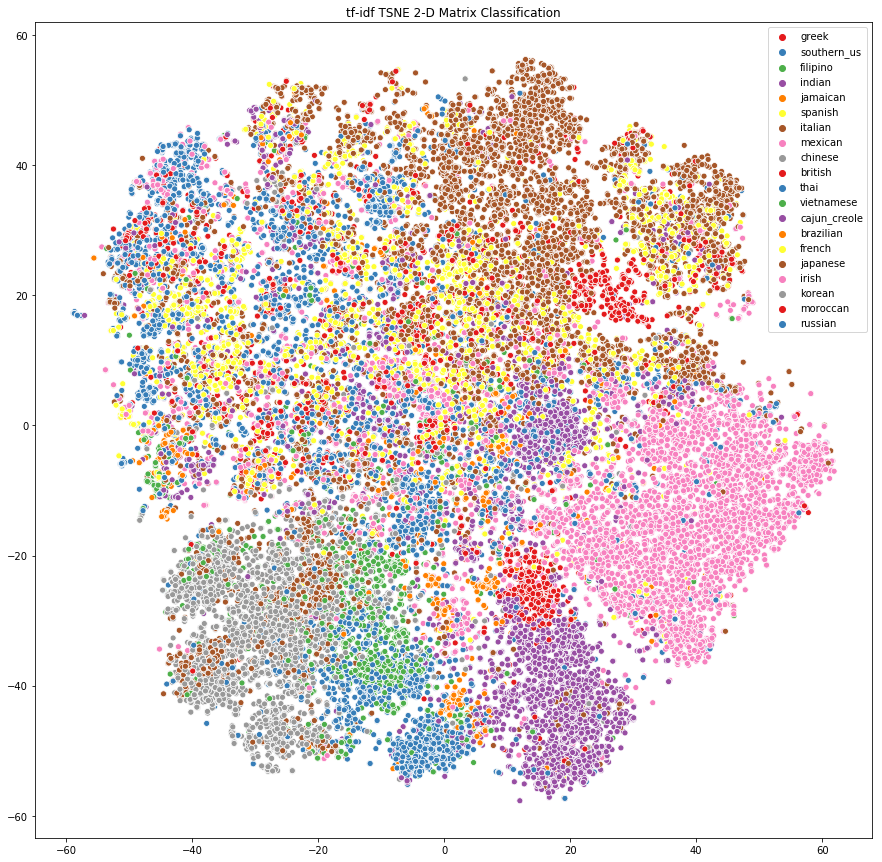

In [361]:
#visualize tsne results (no tf-idf; should look better with different vectorization technique)
fig, ax = plt.subplots(figsize=(15,15))

sns.scatterplot(x=X_2d[:,0], y=X_2d[:,1], hue=y_train.values, palette="Set1", ax=ax)
plt.title("tf-idf TSNE 2-D Matrix Classification")

# Engagment of Class 

We've created a short questionnaire as a human test of how well individuals can predict a cuisine type based on a list of ingredients. This survey is used as a quick and engaging way for the class to test their capability and also used as a comparative data for our predictive model. After analyzing the results, it was rare to see that individuals who took our questionnaire predicted the correct cuisine type more than 40% of time, meaning that our model, even though it didn't have a fantastic accuracy, had a better accuracy than the students of 370.

## Limitations and Challenges 

This data set was challenging to work with in more ways than one. Recipes are diverse and come from different cultures and countries. Our data set contained thousands of recipes, each with their own set of ingredients. This created our first problem cleaning the data set and quantifying qualitative data. The ingredients in our dataset were, to a degree, infinite and qualitative. So our first step was to turn the ingredients into 1's and 0's for the purpose of Machine Learning. When we did that....our Data Frame became massive and practically unnavigable. Thus we jumped right into cleaning the data set, so we could process it better and create better models. We first removed Ingredients that weren't used at all and those that were used minimal amounts of times. We further cleaned the data by running a feature importance test and removing those ingredients that really didn't factor into the model at all. We also ran into shaping issues with our data set. Due to the cleaning of the original dataset, we had to figure out a way to match our raw data set to our test data as it wasn't shaped in the same way as our training data.

After the preparation phase, our next major challenge was improving the accuracy of our model and figuring out the best ways to create the best model. Our model wasn't necessarily making Binary decisions, so we had to find a happy medium within our hyper parameters to create the best model. For example, shallow trees with low depths weren't very accurate because the trees were most likely not given the best depth to learn. Likewise, overfitting the trees with depths upwards of 94 were overfitting the model. We had to find a depth that gave us a decent accuracy score without overfitting or just being outright wrong. This did lead us to find what cuisines were similar. When increasing the depth of the model, you could see similar cuisines being matched. For example, Philipino cuisine and Japanese cuisines were getting matched, most likely due to their similar ingredients.

Other limitations of our data were just knowing when to stop with cleaning and figuring out the best way to standardize column names. For example, we attempted to use NLP to work with the qualitative data in our data set. Asking ourselves questions like: Should we Stem? Should we Lemmatize?. It was hard because the ingredient list was huge and the ingredients weren't always one word. Likewise, as we are standardizing columns, how do we know which columns to cut? Some ingredients may be more indicative and decisive than other ingredients.

Overall, this project was really fun but super challenging due to the diversity and length of the data. We learned a lot about cleaning, standardizing and manipulating data to fit the data. Likewise, we learned a lot about giving good data to our models and creating good models for our data (i.e not overfitting.) Lastly, we enjoyed learning about all these different cultures and recipes. The world is truly ripe with diverse foods and cultures, and we were very excited to explore it!

## Main Findings: 

#### Random test
When running the test randomly, we came up with around a 5% accuracy rate for predicting labels. Running this helped us see what we could approve upon, as well as set a base line for what we should be beating.

#### Random Forest
Our random forest model came out with a 63% accuracy for predicting cuisine labels. While this was not ideal, we still were able to see that it was far better than a random test, and about 20% better than our classmate's responses (real people!). Our findings from our decision tree were largely stifled by its poor accuracy, which we believe stems from the large amount of different features (thousands of ingredients).

#### NLP version
To improve our accuracy, we tried to take an NLP approach with this dataset, performing Logistic Regression, Decision Tree, Random Forest, Linear SVC, and truncated SVD under both a bag of words and tfidf approach. What we found was that although using any NLP approach improved our accuracy over the regular random forest model, we saw that there wasn’t much difference between bag of words and tfidf based on our results, and that for both models, the best performing ones are log regression and linear SVC, with accuracy in the high 70s.

## Recommendations for Future Work

Moving forward, we would've liked to had more of a chance to better clean the data, to figure out what we could get rid of in hopes of improving our model accuracy. This could look like using n-grams or more pre-processing to capture “ingredients” rather than just the words (e.g. soy_sauce instead of soy sauce). Lastly, we recommend recreating this work and putting it into a pipeline format, for easy or reading and running.